In [21]:
import gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam
# import rl
# from rl.agents import DQNAgent
# from rl.policy import BoltzmannQPolicy
# from rl.memory import SequentialMemory
# from keras import backend as K
# from keras.layers import Activation, Dense, Input
# from keras.models import Model
# from keras.optimizers import Adam

In [22]:
max_episodes = 5000
max_steps = 200
test_episodes = 1000
alpha = 0.1
gamma = 0.95
epsilon = 1.0
decay_rate = 0.01

In [53]:
class RandomAgent:

    def __init__(self, max_episodes, max_steps, test_episodes):
        self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
        self.max_episodes = max_episodes
        self.test_episodes= test_episodes
        self.steps = max_steps
        self.reward_arr = np.empty(max_episodes)
        self.count_solved = 0
        
    def run(self):
        print("Running...")
        for episode in range(self.max_episodes):
            state = self.env.reset()
            done = False
            eps_reward = 0
            for step in range(self.steps):
                action = self.env.action_space.sample()
                new_state, reward, done, info, _ = self.env.step(action)
                eps_reward += reward
                state = new_state
                if done == True: 
                    self.count_solved +=1
                    self.reward_arr[episode] = eps_reward
                    eps_reward = 0
                    break
                self.reward_arr[episode] = eps_reward
            eps_reward = 0
        print("Done!")
        self.plot_rewards()
        self.info_rewards()
        
        
    def plot_rewards(self):
        plt.figure(figsize=(15,8))
        plt.title("Total Reward per episodes for random algorithm")
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.ylim(-400, 20)
        plt.grid()
        plt.plot(self.reward_arr, label = 'Random Agent', color = "red")
        plt.legend()
        plt.show()  
        
        
    def info_rewards(self):
        print("Number of times passenger was dropped off: {}".format(self.count_solved))
        print("Max reward: {}".format(max(self.reward_arr)))
        print("Min reward: {}".format(min(self.reward_arr)))
        print("Avg reward: {}".format(sum(self.reward_arr)/self.max_episodes))

In [54]:
randAgent = RandomAgent(max_episodes, max_steps, test_episodes)

Running...
Done!


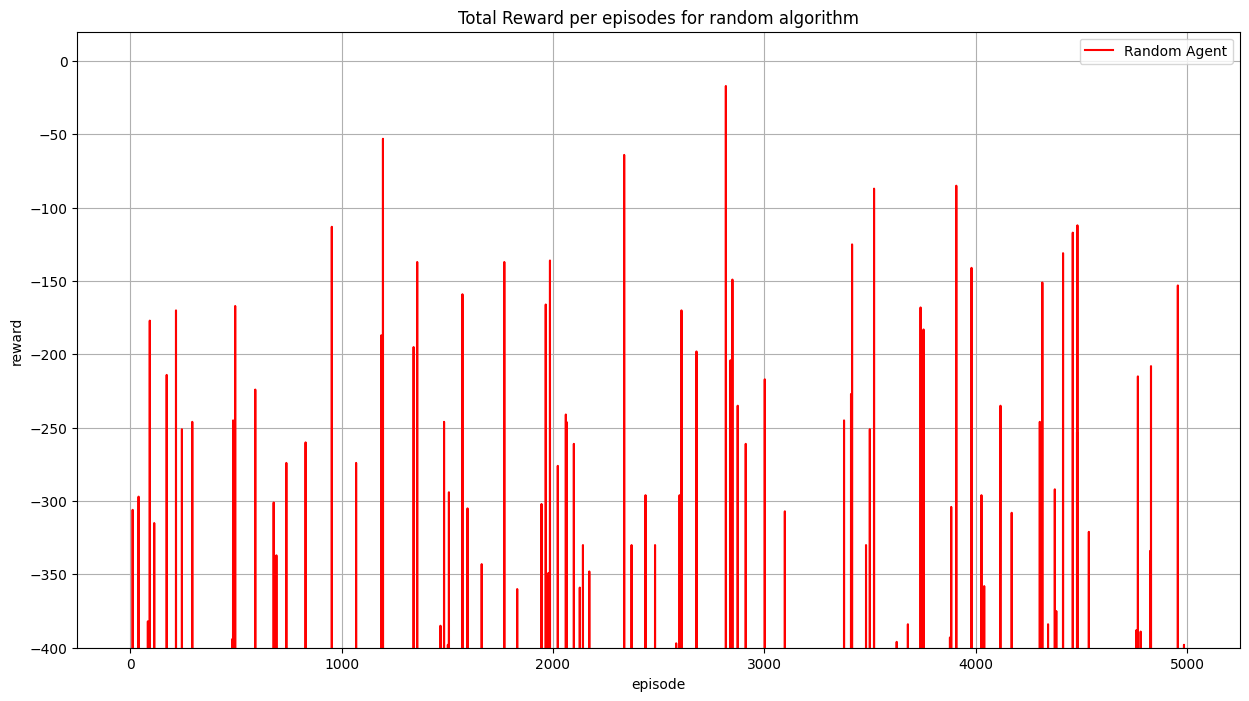

Number of times passenger was dropped off: 230
Max reward: -17.0
Min reward: -1010.0
Avg reward: -767.9964


In [55]:
randAgent.run()

In [65]:
class Q_Agent:
    def __init__(self, max_episodes, max_steps, test_episodes, alpha, gamma, epsilon, decay_rate):
        self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
        self.qtable = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.max_episodes = max_episodes
        self.test_episodes= test_episodes
        self.steps = max_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.reward_arr = np.empty(max_episodes)
        self.decay_rate = decay_rate
        self.count_solved = 0
        
        
    def run(self):
        print("Training....")
        for episode in range(self.max_episodes):
#             print("Episode: {}".format(episode))
            state = self.env.reset()
            done = False
            eps_reward = 0
            
            for step in range(self.steps):
                exp_exp_tradeoff = random.uniform(0,1)
                if exp_exp_tradeoff > self.epsilon:
                    if type(state) == tuple:
                        action = np.argmax(self.qtable[state[0],:])
                    else:
                        action = np.argmax(self.qtable[state,:])
                
                else:
                    action = self.env.action_space.sample()
                
                new_state, reward, done, info, _ = self.env.step(action)
                eps_reward += reward
#                 print("reward: {}".format(reward))
                if type(state) == tuple:
                    self.qtable[state[0], action] = self.qtable[state[0], action] + self.alpha * (reward + self.gamma * 
                                            np.max(self.qtable[new_state, :]) - self.qtable[state[0], action])
                else:
                    self.qtable[state, action] = self.qtable[state, action] + self.alpha * (reward + self.gamma * 
                                            np.max(self.qtable[new_state, :]) - self.qtable[state, action])
                    
                state = new_state

                if done == True: 
                    self.count_solved += 1
                    self.reward_arr[episode] = eps_reward
                    eps_reward = 0
                    break
                self.reward_arr[episode] = eps_reward
            eps_reward = 0
        
        # Reduce epsilon (because we need less and less exploration)
            self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-self.decay_rate*episode) 
            
        print("Learning done!")
        self.plot_rewards()
        self.info_rewards()
        
    
            
        
        
    def plot_rewards(self):
        plt.figure(figsize=(15,8))
        plt.title("Total Reward per episodes for Q learning")
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.ylim(-400, 20)
        plt.grid()
        plt.plot(self.reward_arr, "-r")
        plt.show()     
        
    def info_rewards(self):
        print("Number of times passenger was dropped off: {}".format(self.count_solved))
        print("Max reward: {}".format(max(self.reward_arr)))
        print("Min reward: {}".format(min(self.reward_arr)))
        print("Avg reward: {}".format(sum(self.reward_arr)/self.max_episodes))

    

Training....
Learning done!


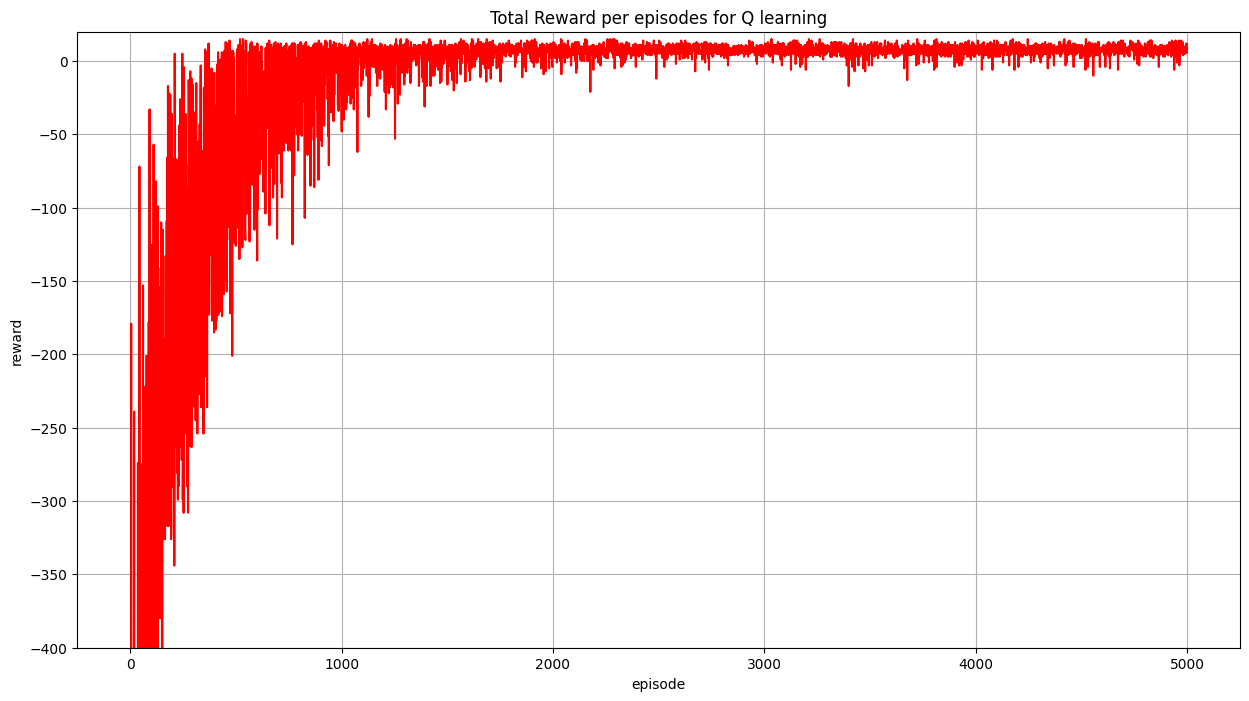

Number of times passenger was dropped off: 4814
Max reward: 15.0
Min reward: -893.0
Avg reward: -20.0562


In [67]:
agent = Q_Agent(max_episodes, 
                max_steps, 
                test_episodes, 
                alpha,
                gamma, 
                epsilon, 
                decay_rate)
agent.run()

In [62]:
class SarsaAgent:
    def __init__(self, max_episodes, max_steps, test_episodes, alpha, gamma, epsilon, decay_rate):
        self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
        self.max_episodes = max_episodes
        self.steps = max_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.reward_list= np.empty(max_episodes)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_solved = 0
        
        
    def chooseAction(self,state):
        action = 0
        if np.random.uniform(0,1) <self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q[state,:])
        return action
    
    def updateQ(self, state, action, state1, action1, reward):
        currentQ = self.Q[state,action]
        self.Q[state,action] = currentQ + float(self.alpha *( reward + 
                                                             (self.gamma *self.Q[state1,action1]) - currentQ))
        
    def run(self):
        print("Training...")
        for eps in range(self.max_episodes):
            state = self.env.reset()
            action1 = self.chooseAction(state[0])
            eps_reward = 0
            for step in range(self.steps):
                #take action 
                new_state, reward, done, info, _ = self.env.step(action1)
                
                #get next action
                action2 = self.chooseAction(new_state)
                        
                #Update Q table with next action
                if type(state) == tuple:
                    self.updateQ(state[0],action1, new_state , action2, reward)
                    
                else: 
                    self.updateQ(state,action1,new_state, action2, reward)
                
                #keep track of reward
                eps_reward+=reward
                
                #overwrite state and action value
                state = new_state
                action1 = action2
                
                if done:
                    self.count_solved += 1
                    break
            self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-self.decay_rate*eps) 
            self.reward_list[eps]= eps_reward
#             print(f"ep : {eps} , reward : {eps_reward}")
            eps_reward = 0
        print("Learning done!")
        self.plot_rewards()
        self.info_rewards()
            
    def plot_rewards(self):
        plt.figure(figsize=(15,8))
        plt.title("Total Reward per episodes for SARSA")
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.ylim(-400, 20)
        plt.grid()
        plt.plot(self.reward_list, "-r")
        plt.show()  
        
        
    def info_rewards(self):
        print("Number of times passenger was dropped off: {}".format(self.count_solved))
        print("Max reward: {}".format(max(self.reward_list)))
        print("Min reward: {}".format(min(self.reward_list)))
        print("Avg reward: {}".format(sum(self.reward_list)/self.max_episodes))    
    
    def export_csv(self):
        df = pd.DataFrame(self.Q)
        df.to_csv("sara_qtable.csv",index = False)


   

Training...
Learning done!


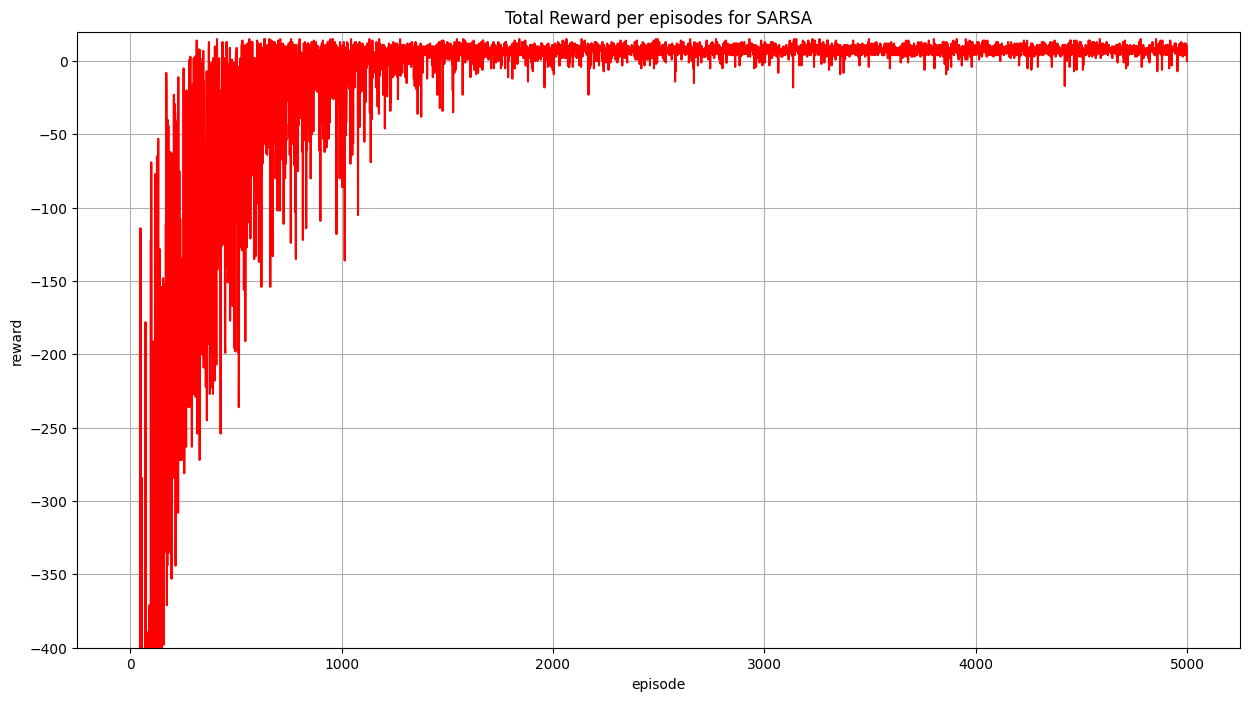

Number of times passenger was dropped off: 4810
Max reward: 15.0
Min reward: -884.0
Avg reward: -21.0672


In [64]:
agent = SarsaAgent(max_episodes, 
                max_steps, 
                test_episodes, 
                alpha, 
                gamma, 
                epsilon, 
                decay_rate)
agent.run()


In [ ]:
# class ActorCriticAgent(object):
#     def __init__(self, max_episodes, max_steps, alpha, beta, gamma):
#         self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
#         self.alpha = alpha
#         self.beta = beta
#         self.max_episodes = max_episodes
#         self.max_steps = max_steps
#         self.gamma = gamma
#         self.fc1_dims = 1024
#         self.fc2_dims = 512
        
#         self.actor, self.critic, self.policy = self.build_actor_critic_network()
#         self.action_space = [i for i in range(self.env.action_space.n)]
        
#     def build_actor_critic_network(self):
#         input = Input(shape = (self.env.observation_space.n,))
#         delta = Input(shape=[1])
#         dense1 = Dense(self.fc1_dims, activation = 'relu')(input)
#         dense2 = Dense(self.fc2_dims, activation = 'relu')(dense1)
#         porbs = Dense(self.env.action_space.n, activation = 'softmax')(dense2)
#         values = Dense(1, activation = 'linear')
        
#         def custom_loss(y_true, y_pred):
#             out = K.clip(y_pred, le-8, 1-le-8)
#             log_lik = y_true*K.log(out)
            
#             return K.sum(-log_lik*delta)
        
#         actor = Model(input[input, delta], output = [probs])
        
#         actor.compile(optimizer = Adam(lr = self.alpha), loss = custom_loss)
        
#         critic = Model(input = [input], output = [values])
        
#         critic.compile(optimizer = Adam, lr = self.beta, loss = 'mean_squares_error')
        
#         policy = Model(input = [input], output = probs)
        
#         return actor, critic, policy
    
#     def choose_action(self, observation):
#         state = observation[np.newaxis, :]
#         porbabilites = self.policy.predict(state)[0]
#         action = np.random.choice(self.action_space, p=probabilities)
        
#         return action
    
#     def learn(self, state, action, reward, state_, done):
#         state = state[np.newaxis, :]
#         state_ = state_[np.newaxis, :]
        
#         critic_value_ = self.critic.predict(state_)
#         critic_value = self.critic.predict(state)
        
#         target = reward + self.gamma*critic_value_*(1-int(done))
#         delta = target - critic_value
        
#         actions = np.zeros([self.n_actions])
#         actions[np.arrange(1), action] = 1.0
        
#         self.actor.fit([state, delta], actions, verbose = 0)
#         self.critic.fit(state, target, verbose = 0)
        
        

In [ ]:
# acAgent = ActorCriticAgent(max_episodes = 1000, 
#                            max_steps = 100, 
#                            alpha = 0.00001, 
#                            beta = 0.00005, 
#                            gamma =0.95)

In [ ]:
# class DQN_Agent:
#     def __init__(self, max_episodes, max_steps, test_episodes, alpha, gamma, epsilon, decay_rate):
#         self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
#         self.qtable = np.zeros((self.env.observation_space.n, self.env.action_space.n))
#         self.max_episodes = max_episodes
#         self.test_episodes= test_episodes
#         self.steps = max_steps
#         self.alpha = alpha
#         self.gamma = gamma
#         self.epsilon = epsilon
#         self.reward_arr = np.empty(max_episodes)
#         self.decay_rate = decay_rate
        
#     def build_model(self):
#         model = tf.keras.Sequential()
#         model.add(Flatten(input_shape = (1, self.env.observation_space.n)))
#         model.add(Dense(24, activation = 'relu'))
#         model.add(Dense(24, activation = 'relu'))
#         model.add(Dense(self.env.action_space.n, activation = 'linear'))
#         self.model = model
        
#     def run(self):
        
        
    
        
        

In [ ]:
# dqn_agent = DQN_Agent(max_episodes = 5000, 
#                 max_steps = 100, 
#                 test_episodes = 1000, 
#                 alpha = 0.1, 
#                 gamma = 0.95, 
#                 epsilon = 1.0, 
#                 decay_rate = 0.01)

In [ ]:
# dqn_agent.build_model()

In [ ]:
# dqn_agent.model.summary()